In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import accuracy_score
from win32comext.adsi.demos.scp import verbose

sys.path.append('../../Share/')
sys.path.append('../V1 - Semi Supervised Learning in online(Pseudo-labeling)/')
import baseline, config
import self_supervised_v1

import warnings
warnings.filterwarnings('ignore')

def plot_result(result):
    plt.figure(figsize=(10, 5))
    plt.plot(result.history['accuracy'], label='accuracy', marker='o')
    plt.plot(result.history['val_accuracy'], label='val_accuracy', marker='o')
    plt.title('Pre-training Stage')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()



SUBJECT = "Hunmin"
trainer = baseline.ModelTrainer(config, subject=SUBJECT)
trainer_Carlson = baseline.ModelTrainer(config, subject="Carlson")
trainer_Harold = baseline.ModelTrainer(config, subject="Harold")
#trainer_Hunmin = baseline.ModelTrainer(config, subject="Hunmin")
trainer_Brian = baseline.ModelTrainer(config, subject="Brian")
trainer_Xianyu = baseline.ModelTrainer(config, subject="Xianyu")

New paradigm : Gesture detection first / Classification Second
- Two models : Detection model / Classification model
- Detection Model
    - We acquire the dataset first

In [2]:
Threshold_K = 22  # 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
#X_init.shape, y_init.shape, X_init_test.shape, y_init_test.shape
mask_train = y_init != 0
X_init_5cls = X_init[mask_train]
y_init_5cls = y_init[mask_train]-1

# 테스트 데이터에서 0 제거
mask_test = y_init_test != 0
X_init_test_5cls = X_init_test[mask_test]
y_init_test_5cls = y_init_test[mask_test]-1

Dataset 1/58 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/58 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/58 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/58 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/58 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/58 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/58 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/58 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/58 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/58 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
Dataset 11/58 - Session Exp_2025-06-23-v1/E9AD0E7DCC2B/
Dataset 12/58 - Session Exp_2025-06-23-v2/E9AD0E7DCC2B/
Dataset 13/58 - Session Exp_2025-06-23-v3/E9AD0E7DCC2B/
Dataset 14/58 - Session Exp_2025-06-23-v4/E9AD0E7DCC2B/
Dataset 15/58 - Session Exp_2025-06-24-v1/E9AD0E7DCC2B/
Dataset 16/58 - Session Exp_2025-06-24-v2/E9AD0E7DCC2B/
Dataset 17/58 - Session Exp_2025-06-24-v3/E9AD0E7DCC2B/
Dataset 18/58 - Session Exp_2025-06-24-v4/E9AD0E7DCC2B/
Dataset

In [3]:
y_test_b = np.where(y_init_test == 0, 0, 1)
y_train_b = np.where(y_init == 0, 0, 1)

X_train_b = X_init.reshape(X_init.shape[0], -1)  # (150202, 56)
X_test_b = X_init_test.reshape(X_init_test.shape[0], -1)     # test 데이터도 같이

y_test_b.shape, y_train_b.shape, X_train_b.shape, X_test_b.shape

((37548,), (150202,), (150202, 56), (37548, 56))

In [4]:
#self_supervised_v1.grid_search_model_LGBM(X_train_b, y_train_b, X_test_b, y_test_b)

In [19]:
Detection_model = self_supervised_v1.detection_model_XGB()
Detection_model.fit(X_train_b, y_train_b)
y_pred = Detection_model.predict(X_test_b)
acc = accuracy_score(y_test_b, y_pred)
print(f"\nAccuracy: {acc:.4f}")


Accuracy: 0.9639


In [5]:
Detection_model = self_supervised_v1.detection_model_LGBM()
Detection_model.fit(X_train_b, y_train_b)
y_pred = Detection_model.predict(X_test_b)
acc = accuracy_score(y_test_b, y_pred)
print(f"\nAccuracy: {acc:.4f}")

[LightGBM] [Info] Number of positive: 59352, number of negative: 90850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11180
[LightGBM] [Info] Number of data points in the train set: 150202, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.395148 -> initscore=-0.425724
[LightGBM] [Info] Start training from score -0.425724

Accuracy: 0.9648


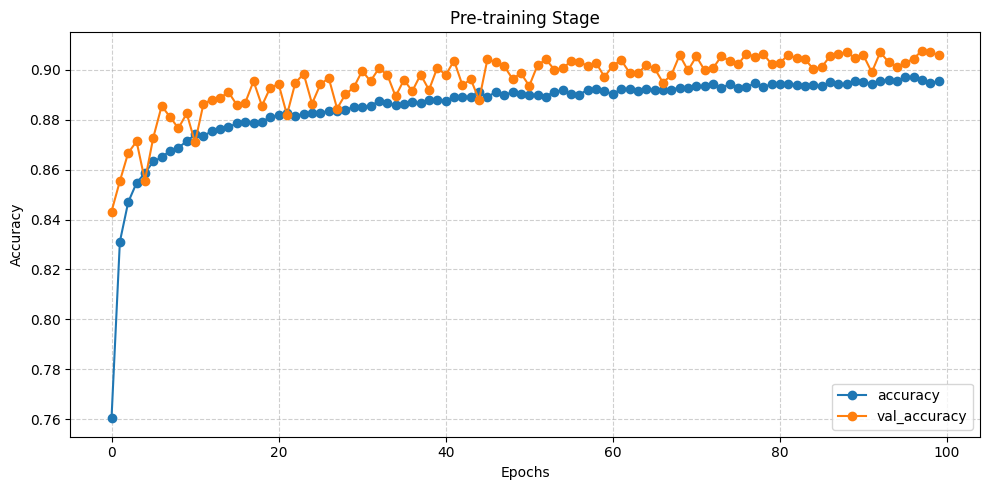

In [6]:
Recognition_model = self_supervised_v1.build_model_after_detection(num_classes=5)  # 모델 생성 및 초기 학습
result = Recognition_model.fit(X_init_5cls, y_init_5cls, validation_data=(X_init_test_5cls, y_init_test_5cls), epochs=100, batch_size=64, verbose=0)
plot_result(result)
Recognition_model.save('./Recognition_model_5CLS.h5')

#from tensorflow.keras.models import load_model
#model = load_model('my_model.h5')

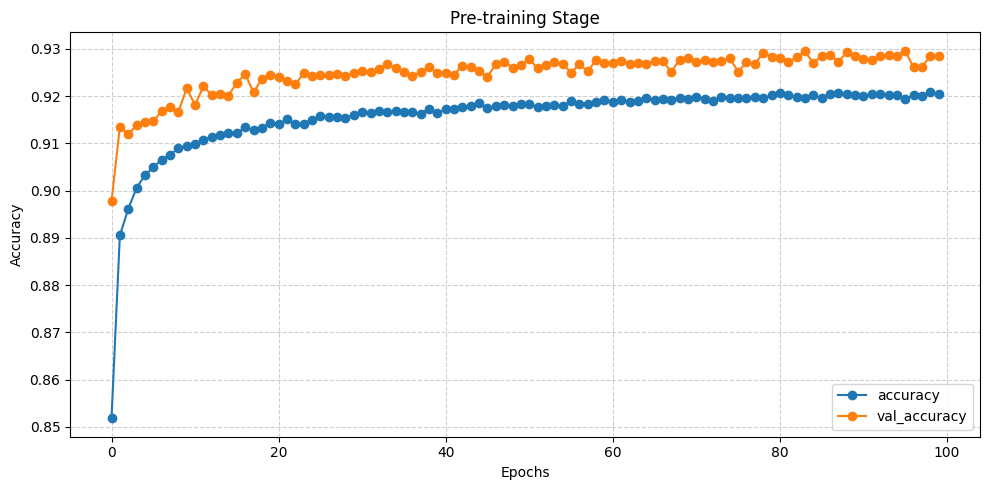

In [20]:
Recognition_model = self_supervised_v1.build_model(num_classes=6)  # 모델 생성 및 초기 학습
result = Recognition_model.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
plot_result(result)
Recognition_model.save('./Recognition_model_6CLS.h5')

In [21]:
#y_recognition = Recognition_model.predict(X_init_test)
acc = Recognition_model.evaluate(X_init_test, y_init_test, verbose=0)[1]
acc

0.9285714030265808

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Detection 단계
y_pred = Detection_model.predict(X_test_b)
gesture_mask = y_pred == 1

# Detection 결과로부터 Recognition input 생성
X_gesture_only = X_test_b[gesture_mask]
y_gesture_true = y_init_test[gesture_mask]-1  # ← 정답 라벨 => 여기서 0을 없애야함

# reshape to (samples, 4, 14, 1)
X_gesture_only = X_gesture_only.reshape(-1, 4, 14, 1)

# Recognition 단계
y_recognition = Recognition_model.predict(X_gesture_only)

# 만약 Recognition_model이 확률을 반환한다면, 가장 큰 값을 가진 인덱스로 변환
#if len(y_recognition.shape) > 1 and y_recognition.shape[1] > 1:
y_recognition = np.argmax(y_recognition, axis=1)

# 정확도 및 보고서 출력
acc = accuracy_score(y_gesture_true, y_recognition)
cm = confusion_matrix(y_gesture_true, y_recognition)
report = classification_report(y_gesture_true, y_recognition)

print(f"Accuracy: {acc:.4f}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(report)

472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
Accuracy: 0.8612
Confusion Matrix:
[[2376  153   23    4  413    0]
 [  49 2703   49   10  128    0]
 [   6   42 2689    4   35    0]
 [   2   15  114 2691    4    0]
 [ 123   72   60    1 2535    0]
 [ 121   97  315  148  107    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      2969
           1       0.88      0.92      0.90      2939
           2       0.83      0.97      0.89      2776
           3       0.94      0.95      0.95      2826
           4       0.79      0.91      0.84      2791
         255       0.00      0.00      0.00       788

    accuracy                           0.86     15089
   macro avg       0.72      0.76      0.74     15089
weighted avg       0.82      0.86      0.84     15089



In [15]:
'''unique, counts = np.unique(y_gesture_true, return_counts=True)
print(dict(zip(unique, counts)))
len(y_gesture_true)
unique, counts = np.unique(y_recognition, return_counts=True)
print(dict(zip(unique, counts)))
len(y_recognition)'''

{np.uint8(0): np.int64(2969), np.uint8(1): np.int64(2939), np.uint8(2): np.int64(2776), np.uint8(3): np.int64(2826), np.uint8(4): np.int64(2791), np.uint8(255): np.int64(788)}


15089

Decoupling to Detection and Classification model

- Detection acc: 96%
- Classification acc after detection: 86%
---
- Without Detection - Classification acc: 92.85